## Chapter 7
# Data Generation

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import ceil
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from sample import Sample
from dataset import Dataset
from database import Database
from sample_detector import SampleDetector
from dataset_simulation import DatasetSimulation
from data_aug.data_aug import *
from data_aug.bbox_util import *

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'
my_dataset = Dataset(dataset_loc, site)
my_database = Database(dataset_loc, database_loc, site)
dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)

## SIMULATED YOLO DATA

### Noise and Whistler Analysis of Marion Data

In [3]:
import multiprocessing as mp
from sklearn import mixture
import scipy.stats as stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

site = 'marion'
components = 1
my_dataset = Dataset(dataset_loc, site)
def get_spec(file):
    sample = Sample(dataset_loc, site, file)
    spec = sample.get_spectrogram()
    cuts, whistler_len, _ =  sample.cuts(cut_time=0.8, cut_time_split=0.3, cut_freq=9, cut_freq_min=1, time_err=0.3, noise=True)
    whistler_cuts, noise_cuts = cuts[:whistler_len],cuts[whistler_len:]
    noise_spec = np.array([spec[cut[0]:cut[1],cut[2]:cut[3]].flatten() for cut in noise_cuts]).flatten()
    whistler_spec = np.array([spec[cut[0]:cut[1],cut[2]:cut[3]].flatten() for cut in whistler_cuts]).flatten()
    return whistler_spec, noise_spec
files = my_database.get_train()
whistler_specs, noise_specs = [], []
pool = mp.Pool(mp.cpu_count())
# generate 1D array of all spectrogram data
for w_spec, n_spec in tqdm(pool.imap_unordered(get_spec, files), total=len(files)):
    if len(w_spec)>0:
        whistler_specs.append(w_spec)
    if len(n_spec)>0:
        noise_specs.append(n_spec)
pool.close()
pool.join()
print(len(whistler_specs), len(noise_specs))

100%|██████████| 1471/1471 [00:57<00:00, 25.55it/s]


1471 1446


##### **Whistlers**
To simulate the whistlers, we can also vary the magnitude based on $\mu_{whistlers}+k\sigma_{whistlers}$

100%|██████████| 1471/1471 [00:56<00:00, 26.15it/s]



Whistler
Mean = 1.415+-0.256
Std = 0.444+-0.045
1 [1.] [[1.42005796]] [[[0.27028105]]]


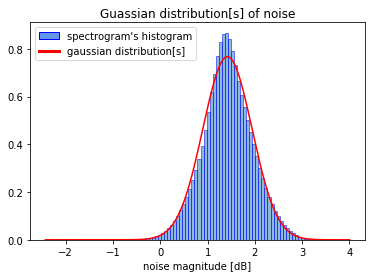

In [4]:
whistler_stats = []
gaussian_whistler_spec = []
for w_spec in tqdm(whistler_specs):
    gaussian_whistler_spec = np.concatenate((gaussian_whistler_spec, w_spec.flatten()))
    whistler_stats.append([w_spec.mean(), w_spec.std()])
gaussian_whistler_spec = np.array(gaussian_whistler_spec)
whistler_stats = np.array(whistler_stats)
print('\nWhistler')
print('Mean = %0.3f+-%.3f'%(whistler_stats[:,0].mean(),whistler_stats[:,0].std()))
print('Std = %0.3f+-%.3f'%(whistler_stats[:,1].mean(),whistler_stats[:,1].std()))

# create Gaussian mixture of the data
gaussian_whistler_spec = gaussian_whistler_spec.reshape(-1,1)
g = mixture.GaussianMixture(n_components=components,covariance_type='full')
g.fit(gaussian_whistler_spec)
weights, means, covars = g.weights_, g.means_, g.covariances_
print(components, weights, means, covars)
plt.figure()
legend = [Patch(facecolor='cornflowerblue', edgecolor='b',label='spectrogram\'s histogram'),
                  Line2D([0], [0], color='red', lw=3, label='gaussian distribution[s]')]
plt.hist(gaussian_whistler_spec, bins=100, histtype='bar', density=True, ec='blue', alpha=0.5)
f_axis = gaussian_whistler_spec.copy().ravel()
f_axis.sort()
for i in range(components):
    plt.plot(f_axis,weights[i]*stats.norm.pdf(f_axis,means[i],np.sqrt(covars[i])).ravel(), c='red')
plt.xlabel('noise magnitude [dB]')
plt.legend(handles=legend, loc='upper left')
plt.title('Guassian distribution[s] of noise')
plt.show()

##### **Noise**
To simulate the noise, we can also vary the magnitude based on the distribution with $\mu_{noise}$ and $\sigma_{noise}$

100%|██████████| 1446/1446 [00:27<00:00, 51.83it/s]



Noise
Mean = 1.356+-0.254
Std = 0.456+-0.056
1 [1.] [[1.35582071]] [[[0.27350395]]]


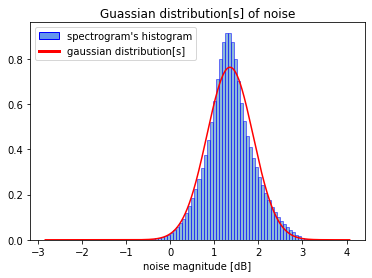

In [5]:
noise_stats = []
gaussian_noise_spec = []
for n_spec in tqdm(noise_specs):
    gaussian_noise_spec = np.concatenate((gaussian_noise_spec, n_spec.flatten()))
    noise_stats.append([n_spec.mean(), n_spec.std()])
gaussian_noise_spec = np.array(gaussian_noise_spec)
noise_stats = np.array(noise_stats)
print('\nNoise')
print('Mean = %0.3f+-%.3f'%(noise_stats[:,0].mean(),noise_stats[:,0].std()))
print('Std = %0.3f+-%.3f'%(noise_stats[:,1].mean(),noise_stats[:,1].std()))

# create Gaussian mixture of the data
components = 1 
gaussian_noise_spec = gaussian_noise_spec.reshape(-1,1)
g = mixture.GaussianMixture(n_components=components,covariance_type='full')
g.fit(gaussian_noise_spec)
weights, means, covars = g.weights_, g.means_, g.covariances_
print(components, weights, means, covars)
plt.figure()
legend = [Patch(facecolor='cornflowerblue', edgecolor='b',label='spectrogram\'s histogram'),
                  Line2D([0], [0], color='red', lw=3, label='gaussian distribution[s]')]
plt.hist(gaussian_noise_spec, bins=100, histtype='bar', density=True, ec='blue', alpha=0.5)
f_axis = gaussian_noise_spec.copy().ravel()
f_axis.sort()
for i in range(components):
    plt.plot(f_axis,weights[i]*stats.norm.pdf(f_axis,means[i],np.sqrt(covars[i])).ravel(), c='red')
plt.xlabel('noise magnitude [dB]')
plt.legend(handles=legend, loc='upper left')
plt.title('Guassian distribution[s] of noise')
plt.show()

#### **Generate Whistler Simulated data for Yolo**

In [5]:
import os,sys
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from dataset_yolo import DatasetYolo
dataset_yolo_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'yolo')
dataset_yolo = DatasetYolo(dataset_yolo_loc, 0.006395061728395062, 0.15503875968992248)
dataset_yolo.generate_yolo()
dataset_yolo.yolo_data_split()

100%|██████████| 96160/96160 [04:29<00:00, 357.15it/s]


**Show example of Simulated Yolo Data**

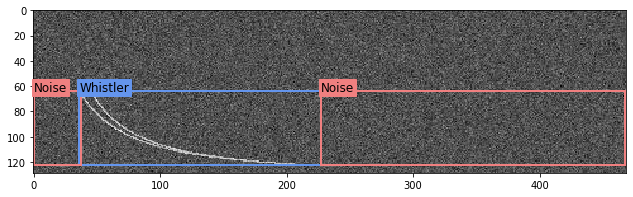

[[0, 0.2814498933901919, 0.7248062015503876, 0.4051172707889126, 0.4573643410852713], [1, 0.039445628997867806, 0.7248062015503876, 0.07889125799573561, 0.4573643410852713], [1, 0.7409381663113006, 0.7248062015503876, 0.5138592750533049, 0.4573643410852713]]


In [2]:
import os,sys
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from dataset_yolo import DatasetYolo
from database import Database
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_yolo_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'yolo')
site = 'marion'

dataset_yolo = DatasetYolo(dataset_yolo_loc, 0.006395061728395062, 0.15503875968992248)
database = Database(dataset_loc, database_loc, site)

data, labels = dataset_yolo.load_yolo_file(dataset_yolo.get_random_yolo())
database.yolo_labelled_img(data, labels, cmap='gray')
print(labels)